In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor, MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve, auc

In [2]:
df = pd.read_csv('^IXIC2.csv')
df

,Date,Close,Close-1,Close-2,Close-3,direction
0,2000/1/4,3727.129883,3877.540039,3901.689941,4131.149902,0
1,2000/1/5,3882.620117,3727.129883,3877.540039,3901.689941,0
2,2000/1/6,4049.669922,3882.620117,3727.129883,3877.540039,0
3,2000/1/7,3921.189941,4049.669922,3882.620117,3727.129883,1
4,2000/1/10,3850.020020,3921.189941,4049.669922,3882.620117,1
...,...,...,...,...,...,...
5880,2023/5/18,12720.780270,12657.900390,12688.839840,12500.570310,1
5881,2023/5/19,12560.250000,12720.780270,12657.900390,12688.839840,0
5882,2023/5/22,12484.160160,12560.250000,12720.780270,12657.900390,1
5883,2023/5/23,12698.089840,12484.160160,12560.250000,12720.780270,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5885 entries, 0 to 5884
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5885 non-null   object 
 1   Close      5885 non-null   float64
 2   Close-1    5885 non-null   float64
 3   Close-2    5885 non-null   float64
 4   Close-3    5885 non-null   float64
 5   direction  5885 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 276.0+ KB


In [4]:
df['Close'] = df['Close'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5885 entries, 0 to 5884
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5885 non-null   object 
 1   Close      5885 non-null   int32  
 2   Close-1    5885 non-null   float64
 3   Close-2    5885 non-null   float64
 4   Close-3    5885 non-null   float64
 5   direction  5885 non-null   int64  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 253.0+ KB


In [5]:
new_df=df.iloc[:,[0,1]].copy()
new_df.head()

,Date,Close
0,2000/1/4,3727
1,2000/1/5,3882
2,2000/1/6,4049
3,2000/1/7,3921
4,2000/1/10,3850


In [6]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000/1/4,3727,NaN,NaN,NaN
1,2000/1/5,3882,3727.0,NaN,NaN
2,2000/1/6,4049,3882.0,3727.0,NaN
3,2000/1/7,3921,4049.0,3882.0,3727.0
4,2000/1/10,3850,3921.0,4049.0,3882.0


In [7]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000/1/7,3921,4049.0,3882.0,3727.0
1,2000/1/10,3850,3921.0,4049.0,3882.0
2,2000/1/11,3957,3850.0,3921.0,4049.0
3,2000/1/12,4064,3957.0,3850.0,3921.0
4,2000/1/13,4130,4064.0,3957.0,3850.0
...,...,...,...,...,...
5877,2023/5/18,12720,12657.0,12688.0,12500.0
5878,2023/5/19,12560,12720.0,12657.0,12688.0
5879,2023/5/22,12484,12560.0,12720.0,12657.0
5880,2023/5/23,12698,12484.0,12560.0,12720.0


In [8]:
x = df.drop(['Date', 'Close','direction'],axis=1).copy()
x.head()

,Close-1,Close-2,Close-3
0,3877.540039,3901.689941,4131.149902
1,3727.129883,3877.540039,3901.689941
2,3882.620117,3727.129883,3877.540039
3,4049.669922,3882.620117,3727.129883
4,3921.189941,4049.669922,3882.620117


In [9]:
y = df['direction'].copy()
y.head()

0    0
1    0
2    0
3    1
4    1
Name: direction, dtype: int64

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=False)

In [11]:
x_train_tuning, x_valid, y_train_tuning, y_valid = train_test_split(x_train,y_train,test_size=0.2,shuffle=False)

In [12]:
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train_tuning)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']
scaled_x_train

,Lag_1,Lag_2,Lag_3
0,0.702357,0.708495,0.766815
1,0.664128,0.702357,0.708495
2,0.703648,0.664128,0.702357
3,0.746106,0.703648,0.664128
4,0.713451,0.746106,0.703648
...,...,...,...
3761,0.897240,0.872719,0.887290
3762,0.923696,0.897240,0.872719
3763,0.928011,0.923696,0.897240
3764,0.932088,0.928011,0.923696


In [13]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

In [14]:
def create_model(learning_rate=0.01):
    # 6.1 Create the model
    clear.clear_session()
    model=Sequential()

    # 6.2 Add input layer & first hidden layer
    model.add(GRU(units=50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

    # 6.3 Add second hidden layer
    model.add(GRU(units=25, return_sequences = True, input_shape = (x_train.shape[1], 1)))

    model.add(Dropout(rate=0.2))

    # 6.4 Add third hidden layer
    model.add(GRU(units=50))

    # 6.5 Add output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # 6.6 Compile the defined Net
    #opt=SGD(learning_rate=0.001,momentum=0.5)
    opt=Adam(learning_rate=learning_rate,beta_1=0.9)
    model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])

    # Finally check the model 
    return model

model = KerasClassifier(build_fn=create_model, epochs=100,verbose=0)
cv_inner = TimeSeriesSplit(n_splits=3)
learning_rate = [0.01,0.001,0.0001]
batch_size = [32,64]
param_grid = dict(batch_size=batch_size,learning_rate=learning_rate)
grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=cv_inner,scoring='neg_root_mean_squared_error',n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

print("Best:%fusing%s"%(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\kevin\AppData\Local\Temp\ipykernel_29596\3005548653.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=100,verbose=0)


Best:-0.685048using{'batch_size': 32, 'learning_rate': 0.01}
-0.685048 (0.033374) with: {'batch_size': 32, 'learning_rate': 0.01}
-0.685048 (0.033374) with: {'batch_size': 32, 'learning_rate': 0.001}
-0.685048 (0.033374) with: {'batch_size': 32, 'learning_rate': 0.0001}
-0.685048 (0.033374) with: {'batch_size': 64, 'learning_rate': 0.01}
-0.685048 (0.033374) with: {'batch_size': 64, 'learning_rate': 0.001}
-0.685048 (0.033374) with: {'batch_size': 64, 'learning_rate': 0.0001}


In [15]:
train_data=df.iloc[0:4707,:].copy()
train_data

,Date,Close,Close-1,Close-2,Close-3,direction
0,2000/1/4,3727,3877.540039,3901.689941,4131.149902,0
1,2000/1/5,3882,3727.129883,3877.540039,3901.689941,0
2,2000/1/6,4049,3882.620117,3727.129883,3877.540039,0
3,2000/1/7,3921,4049.669922,3882.620117,3727.129883,1
4,2000/1/10,3850,3921.189941,4049.669922,3882.620117,1
...,...,...,...,...,...,...
4702,2018/9/12,8010,8013.709961,7954.229980,7972.470215,0
4703,2018/9/13,7895,8010.040039,8013.709961,7954.229980,1
4704,2018/9/14,7956,7895.790039,8010.040039,8013.709961,0
4705,2018/9/17,7950,7956.109863,7895.790039,8010.040039,0


In [16]:
test_data=df.iloc[4707:5884,:].copy()
test_data

,Date,Close,Close-1,Close-2,Close-3,direction
4707,2018/9/19,7986,8028.229980,7950.040039,7956.109863,0
4708,2018/9/20,7993,7986.959961,8028.229980,7950.040039,1
4709,2018/9/21,8007,7993.250000,7986.959961,8028.229980,0
4710,2018/9/24,7990,8007.470215,7993.250000,7986.959961,1
4711,2018/9/25,8041,7990.370117,8007.470215,7993.250000,1
...,...,...,...,...,...,...
5879,2023/5/17,12657,12688.839840,12500.570310,12343.049810,1
5880,2023/5/18,12720,12657.900390,12688.839840,12500.570310,1
5881,2023/5/19,12560,12720.780270,12657.900390,12688.839840,0
5882,2023/5/22,12484,12560.250000,12720.780270,12657.900390,1


In [17]:
x_train_data = train_data.drop(['Date', 'Close','direction'],axis=1).copy()
y_train_data = train_data['direction'].copy()

In [19]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# 6.2 Add input layer & first hidden layer
Fmodel.add(GRU(units=50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

# 6.3 Add second hidden layer
Fmodel.add(GRU(units=25, return_sequences = True, input_shape = (x_train.shape[1], 1)))

Fmodel.add(Dropout(rate=0.2))

# 6.4 Add third hidden layer
Fmodel.add(GRU(units=50))

# 6.5 Add output layer
Fmodel.add(Dense(units=1, activation='sigmoid'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01,beta_1=0.9)
Fmodel.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 50)             7950      
                                                                 
 gru_1 (GRU)                 (None, 3, 25)             5775      
                                                                 
 dropout (Dropout)           (None, 3, 25)             0         
                                                                 
 gru_2 (GRU)                 (None, 50)                11550     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 25,326
Trainable params: 25,326
Non-trainable params: 0
_________________________________________________________________


In [21]:
history=Fmodel.fit(x_train_data, y_train_data, epochs=100, batch_size=32,verbose=1)

Epoch 1/100
148/148 [==============================] - 4s 6ms/step - loss: 0.6940 - accuracy: 0.5303
Epoch 2/100
148/148 [==============================] - 1s 6ms/step - loss: 0.6913 - accuracy: 0.5294
Epoch 3/100
148/148 [==============================] - 1s 6ms/step - loss: 0.6904 - accuracy: 0.5392
Epoch 4/100
148/148 [==============================] - 1s 6ms/step - loss: 0.6908 - accuracy: 0.5392
Epoch 5/100
148/148 [==============================] - 1s 6ms/step - loss: 0.6909 - accuracy: 0.5392
Epoch 6/100
148/148 [==============================] - 1s 6ms/step - loss: 0.6906 - accuracy: 0.5392
Epoch 7/100
148/148 [==============================] - 1s 6ms/step - loss: 0.6907 - accuracy: 0.5392
Epoch 8/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6903 - accuracy: 0.5392
Epoch 9/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6903 - accuracy: 0.5392
Epoch 10/100
148/148 [==============================] - 1s 8ms/step - loss: 0.6903 - accura

148/148 [==============================] - 1s 7ms/step - loss: 0.6907 - accuracy: 0.5392
Epoch 82/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6906 - accuracy: 0.5392
Epoch 83/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6903 - accuracy: 0.5392
Epoch 84/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6903 - accuracy: 0.5392
Epoch 85/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6903 - accuracy: 0.5392
Epoch 86/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6905 - accuracy: 0.5392
Epoch 87/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6903 - accuracy: 0.5392
Epoch 88/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6902 - accuracy: 0.5392
Epoch 89/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6904 - accuracy: 0.5392
Epoch 90/100
148/148 [==============================] - 1s 7ms/step - loss: 0.6903 - accuracy: 

In [22]:
Fmodel.save('NASDAQ_GRU_trained_Classification_model.h5')
print('Model has been saved...')

Model has been saved...


In [23]:
ANN_model=keras.models.load_model('NASDAQ_GRU_trained_Classification_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


In [25]:
x_test_data = test_data.drop(['Date', 'Close','direction'],axis=1).copy()
y_test_data = test_data['direction'].copy()

In [26]:
# 8.1 Make prediction 
prediction=ANN_model.predict_on_batch(x_test_data)
prediction

array([[0.5384515],
       [0.5384515],
       [0.5384515],
       ...,
       [0.5384515],
       [0.5384515],
       [0.5384515]], dtype=float32)

In [27]:
# 8.2 Transform the predictions to 0 and 1 
testing_prediction=(ANN_model.predict_on_batch(x_test_data) >= 0.5).astype('int')
testing_prediction

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

Testing result:
Testing ACC: 54.38
Testing f1s: 70.45
Testing pre: 54.38
Testing sen: 100.0
Testing spe: 0.0

Testing confusion matrix:


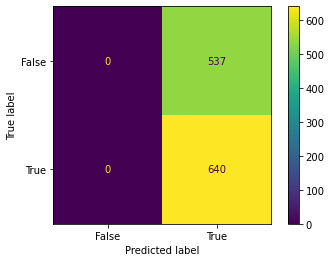

In [28]:
# 8.3 Calculating the mertics
testing_acc=accuracy_score(y_test_data,testing_prediction)
testing_f1s=f1_score(y_test_data,testing_prediction,pos_label=1)
testing_pre=precision_score(y_test_data,testing_prediction,pos_label=1)
testing_sen=sensitivity_score(y_test_data,testing_prediction,pos_label=1)
testing_spe=specificity_score(y_test_data,testing_prediction,pos_label=1)
testing_cm=confusion_matrix(y_test_data,testing_prediction)
testing_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = testing_cm, display_labels = [False, True])
print('Testing result:')
print('Testing ACC:',round(testing_acc*100,2))
print('Testing f1s:',round(testing_f1s*100,2))
print('Testing pre:',round(testing_pre*100,2))
print('Testing sen:',round(testing_sen*100,2))
print('Testing spe:',round(testing_spe*100,2))
print('')
print('Testing confusion matrix:')
testing_cm_display.plot()
plt.show()